In [23]:
import os
import json
import numpy as np
import pandas as pd
#import socket
import requests
#from time import sleep
#from multiprocessing import Pool, cpu_count
from datetime import datetime, time, timedelta
from progressbar import ProgressBar
from pymongo import MongoClient

In [4]:
key = os.environ['DARK_SKY_KEY']
lat = '40.9310'
lon = '-78.9572'

In [5]:
''' sources:
http://www.groundhog.org/about/history/
http://www.groundhog.org/fileadmin/user_upload/siteImages/pdf/Groundhog_Day_Historical_Predictions.pdf
'''
early_spring_years = ['1950', '1970', '1975', '1983', '1986', '1988', '1990', 
                      '1995', '1997', '1999', '2007', '2011', '2013', '2016']

In [6]:
def unix_to_datetime(unix_time):
    '''
    Convert UNIX time to datetime
    
    INPUT:
        unix_time: int, UNIX time (seconds since 1970-01-01 00:00:00)

    OUTPUT:
        new_dt: datetime object, datetime representation of unix_time
    '''
    orig = datetime(1970, 1, 1, 0, 0, 0, 0)
    new_dt = orig + timedelta(seconds=unix_time)
    return new_dt

In [7]:
years = map(str, np.arange(1944, 2018))

for year in years:
    
    time = '{}-02-02T00:00:00'.format(year)
    url = 'https://api.darksky.net/forecast/{}/{},{},{}'.format(key, lat, lon, time)
    try:
        response = requests.get(url)
    except:
        continue
    
    if response.status_code == 200:
        forecast = response.json()
        try:
            print "found data for {}".format(unix_to_datetime(forecast['daily']['data'][0]['time']))
        except:
            continue
    else:
        print "earliest year available: {}".format(int(year) + 1)
        break

found data for 1944-02-02 04:00:00
found data for 1945-02-02 04:00:00
found data for 1946-02-02 05:00:00
found data for 1947-02-02 05:00:00
found data for 1948-02-02 05:00:00
found data for 1949-02-02 05:00:00
found data for 1950-02-02 05:00:00
found data for 1951-02-02 05:00:00
found data for 1952-02-02 05:00:00
found data for 1953-02-02 05:00:00
found data for 1954-02-02 05:00:00
found data for 1955-02-02 05:00:00
found data for 1956-02-02 05:00:00
found data for 1957-02-02 05:00:00
found data for 1958-02-02 05:00:00
found data for 1959-02-02 05:00:00
found data for 1960-02-02 05:00:00
found data for 1961-02-02 05:00:00
found data for 1962-02-02 05:00:00
found data for 1963-02-02 05:00:00
found data for 1964-02-02 05:00:00
found data for 1965-02-02 05:00:00
found data for 1966-02-02 05:00:00
found data for 1967-02-02 05:00:00
found data for 1968-02-02 05:00:00
found data for 1969-02-02 05:00:00
found data for 1970-02-02 05:00:00
found data for 1971-02-02 05:00:00
found data for 1972-

In [134]:
year = 2017
time = '{}-02-02T012:00:00Z'.format(year)
url = 'https://api.darksky.net/forecast/{}/{},{},{}'.format(key, lat, lon, time)

In [169]:
response = requests.get(url)

if response.status_code == 200:
    forecast = response.json()

In [170]:
print unix_to_datetime(forecast['currently']['time'])

2017-02-02 07:00:00


In [171]:
print unix_to_datetime(forecast['hourly']['data'][2]['time'])

2017-02-02 07:00:00


In [172]:
db_client = MongoClient()
db = db_client['groundhog_day']
pred_coll = db['predictions']

In [175]:
forecast['prediction'] = 0

In [177]:
forecast['prediction']

0

In [95]:
df_daily = pd.read_pickle('data/groundhog_daily.pkl')
df_hourly = pd.read_pickle('data/groundhog_hourly.pkl')
df_hourly['precip_type'] = df_hourly['precip_type'].fillna('None')


In [96]:
mask_a = df_hourly['time'] >= time(7, 0)
mask_b = df_hourly['time'] <= time(9, 0)
df_morning = df_hourly[mask_a & mask_b]

df_summaries = pd.DataFrame(columns = df_morning.columns)

In [97]:
dates = df_morning['date'].unique()

for dt in dates:
    new_row = {}
    df_slice = df_morning[df_morning['date'] == dt]
    new_row['actual_temp'] = df_slice['actual_temp'].mean()
    new_row['date'] = dt
    new_row['dew_point'] = df_slice['dew_point'].mean()
    new_row['feels_like_temp'] = df_slice['feels_like_temp'].mean()
    new_row['humidity'] = df_slice['humidity'].mean()
    try:
        new_row['precip_type'] = df_slice['precip_type'].mode()[0]
    except:
        new_row['precip_type'] = 'None'
    new_row['prediction'] = df_slice['prediction'].mean()
    try:
        new_row['summary'] = df_slice['summary'].mode()[0]
    except:
        new_row['summary'] = 'Overcast'
    new_row['time'] = 'morning avg'
    new_row['visibility'] = df_slice['visibility'].mean()
    new_row['wind_bearing'] = df_slice['wind_bearing'].mean()
    new_row['wind_speed'] = df_slice['wind_speed'].mean()
    
    df_summaries = df_summaries.append(pd.Series(new_row), ignore_index=True)

In [98]:
df_summaries

,actual_temp,date,dew_point,feels_like_temp,humidity,precip_type,prediction,summary,time,visibility,wind_bearing,wind_speed
0,19.120000,1944-02-02,8.680000,14.083333,0.633333,snow,0.0,Foggy,morning avg,0.863333,97.666667,5.666667
1,14.513333,1945-02-02,11.946667,1.416667,0.893333,snow,0.0,Foggy,morning avg,1.753333,243.000000,11.020000
2,27.333333,1946-02-02,11.010000,12.376667,0.496667,snow,0.0,Breezy,morning avg,10.000000,270.333333,25.333333
3,20.313333,1947-02-02,15.523333,6.650000,0.813333,snow,0.0,Snow,morning avg,2.316667,258.000000,14.933333
4,10.520000,1948-02-02,7.663333,-3.406667,0.880000,snow,0.0,Foggy,morning avg,1.490000,229.666667,10.790000
5,15.963333,1949-02-02,10.196667,1.846667,0.776667,None,0.0,Partly Cloudy,morning avg,5.146667,279.333333,13.480000
6,33.730000,1950-02-02,33.046667,30.563333,0.973333,rain,1.0,Foggy,morning avg,0.516667,189.666667,4.346667
7,4.910000,1951-02-02,-2.263333,-13.053333,0.713333,None,0.0,Mostly Cloudy,morning avg,3.200000,262.000000,14.910000
8,41.316667,1952-02-02,40.533333,36.510000,0.970000,rain,0.0,Overcast,morning avg,2.523333,240.333333,7.426667
9,13.446667,1953-02-02,5.223333,2.413333,0.693333,None,0.0,Overcast,morning avg,9.016667,108.000000,7.953333


In [62]:
df_test['precip_type'].mode()[0]

u'snow'

In [56]:
df_summaries

,actual_temp,date,dew_point,feels_like_temp,humidity,precip_type,prediction,summary,time,visibility,wind_bearing,wind_speed


In [311]:
df = pd.read_csv('data/groundhog.csv')
df_precip_dummies = pd.get_dummies(df['precip_type'], drop_first=True)
df_condition_dummies = pd.get_dummies(df['condition'], drop_first=True)
df = df.drop(['Unnamed: 0', 'date', 'condition', 'precip_type'], axis=1)
df = pd.concat([df, df_precip_dummies, df_condition_dummies], axis=1)



In [100]:
df_precip_dummies = pd.get_dummies(df_summaries['precip_type'], drop_first=True)
df_summary_dummies = pd.get_dummies(df_summaries['summary'], drop_first=True)
df_summaries = df_summaries.drop(['date', 'precip_type', 'summary', 'time'], axis=1)
df_summaries = pd.concat([df_summaries, df_precip_dummies, df_summary_dummies], axis=1)

In [101]:
df_summaries

,actual_temp,dew_point,feels_like_temp,humidity,prediction,visibility,wind_bearing,wind_speed,rain,snow,Clear,Flurries,Foggy,Light Rain,Light Snow,Mostly Cloudy,Overcast,Partly Cloudy,Rain,Snow
0,19.120000,8.680000,14.083333,0.633333,0.0,0.863333,97.666667,5.666667,0,1,0,0,1,0,0,0,0,0,0,0
1,14.513333,11.946667,1.416667,0.893333,0.0,1.753333,243.000000,11.020000,0,1,0,0,1,0,0,0,0,0,0,0
2,27.333333,11.010000,12.376667,0.496667,0.0,10.000000,270.333333,25.333333,0,1,0,0,0,0,0,0,0,0,0,0
3,20.313333,15.523333,6.650000,0.813333,0.0,2.316667,258.000000,14.933333,0,1,0,0,0,0,0,0,0,0,0,1
4,10.520000,7.663333,-3.406667,0.880000,0.0,1.490000,229.666667,10.790000,0,1,0,0,1,0,0,0,0,0,0,0
5,15.963333,10.196667,1.846667,0.776667,0.0,5.146667,279.333333,13.480000,0,0,0,0,0,0,0,0,0,1,0,0
6,33.730000,33.046667,30.563333,0.973333,1.0,0.516667,189.666667,4.346667,1,0,0,0,1,0,0,0,0,0,0,0
7,4.910000,-2.263333,-13.053333,0.713333,0.0,3.200000,262.000000,14.910000,0,0,0,0,0,0,0,1,0,0,0,0
8,41.316667,40.533333,36.510000,0.970000,0.0,2.523333,240.333333,7.426667,1,0,0,0,0,0,0,0,1,0,0,0
9,13.446667,5.223333,2.413333,0.693333,0.0,9.016667,108.000000,7.953333,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [230]:
df = pd.read_pickle('data/groundhog_daily_scrubbed.pkl')
# df = pd.read_pickle('data/groundhog_hourly_scrubbed.pkl')

y = df.pop('prediction').values
X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [231]:
model = RandomForestClassifier(random_state=42)

In [232]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [233]:
y_pred = model.predict(X_test)
print y_test
print y_pred

[0 0 0 0 0 1 0 0 0 0 1 0 0 1 0]
[0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]


In [234]:
print "Accuracy: ", accuracy_score(y_test, y_pred)
print "Precision: ", precision_score(y_test, y_pred)
print "Recall: ", recall_score(y_test, y_pred)

Accuracy:  0.8
Precision:  0.5
Recall:  0.333333333333


In [109]:
importance_lst = zip(df.columns, model.feature_importances_)
importance_lst.sort(key=lambda x: x[1])
print importance_lst[::-1]

[('dew_point', 0.17732215821991223), ('humidity', 0.11975396626111849), ('min_temp', 0.11316136971876119), ('moon_phase', 0.10190491376853174), ('wind_speed', 0.097304049054677932), ('visibility', 0.088722534435650452), (u'rain', 0.088597470427525804), ('max_temp', 0.086102587881138143), (u'rain', 0.053025216364372442), ('wind_bearing', 0.036426392871019675), (u'snow', 0.021430066791451156), (u'snow', 0.009342031145326047), ('partly-cloudy', 0.0068561540375816753), (u'fog', 2.9250215075113599e-05), (u'wind', 2.1838807858017864e-05)]


In [212]:
# df = pd.read_pickle('data/groundhog_daily_scrubbed.pkl')
df = pd.read_pickle('data/groundhog_hourly_scrubbed.pkl')
df = df.drop(['Mostly Cloudy', 'Clear', 'Partly Cloudy', 'Flurries', 'Light Snow', \
              'Foggy', 'Snow'], axis=1)

y = df.pop('prediction').values
X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [213]:
model = RandomForestClassifier(n_estimators=50, random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [214]:
y_pred = model.predict(X_test)
print y_test
print y_pred

[ 0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  1.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  0.  0.]


In [215]:
print "Accuracy: ", accuracy_score(y_test, y_pred)
print "Precision: ", precision_score(y_test, y_pred)
print "Recall: ", recall_score(y_test, y_pred)

Accuracy:  0.826086956522
Precision:  0.5
Recall:  0.5


In [161]:
importance_lst = zip(df.columns, model.feature_importances_)
importance_lst.sort(key=lambda x: x[1])
print importance_lst[::-1]

[('dew_point', 0.32420642579092762), ('wind_bearing', 0.20823662249663161), ('feels_like_temp', 0.19344516681162599), ('humidity', 0.12844827430766989), ('wind_speed', 0.044929342574939232), ('actual_temp', 0.037806800794978508), ('visibility', 0.029389916085888861), (u'Light Rain', 0.01725967768059607), ('Overcast', 0.011309800380013979), (u'snow', 0.0027359781121750948), (u'rain', 0.0022319949645531125), (u'Rain', 0.0)]


In [244]:
import matplotlib.pyplot as plt
%matplotlib inline

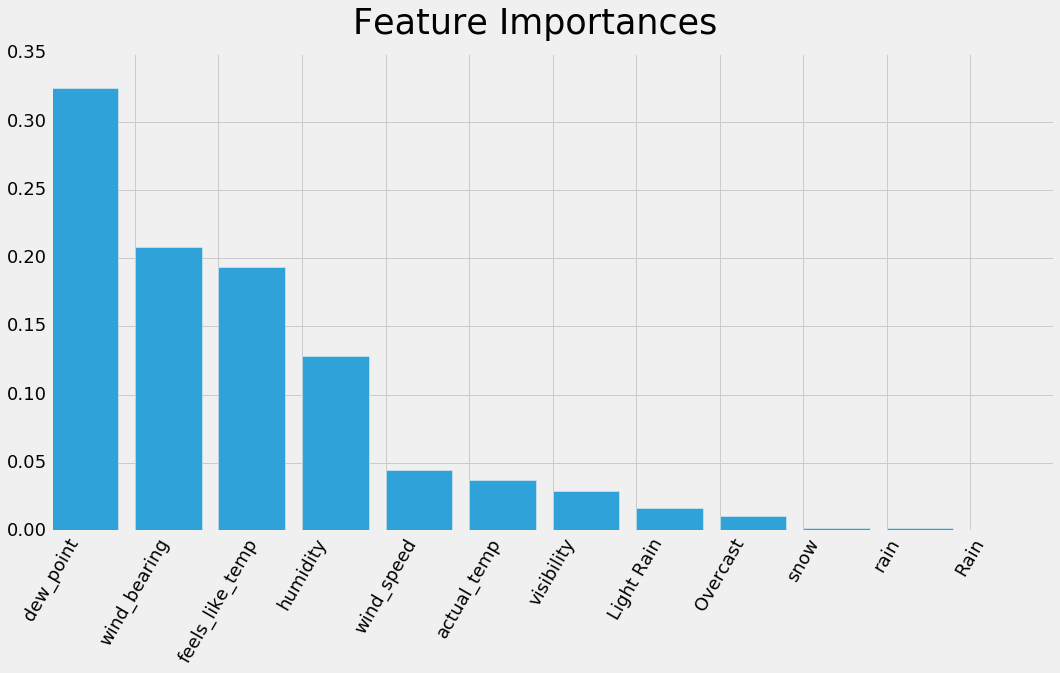

In [266]:
plt.style.use('fivethirtyeight')
labels = [tup[0] for tup in importance_lst[::-1]]
importances = [tup[1] for tup in importance_lst[::-1]]
fig = plt.figure(figsize=(16, 8))
fig.suptitle('Feature Importances', fontsize=35)
ax = fig.add_subplot(111)
ax.bar(range(len(importances)), importances, color='#30a2da')
ax.set_xlabels=labels
plt.xticks(range(len(importances)), labels, rotation=60, fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('img/feature_importance.png')
plt.show()
